# Classical Computer Vision SIFT
Here we implement a computer vision algorithm to search for lookalike signals.

In [1]:
import pandas as pd
import numpy as np
from blimpy import Waterfall
import cv2 as cv

In [2]:
def normalize(data):
    epsilon = 1
    # min_val = data.min()
    # data = data - min_val + epsilon
    # new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data

# Load SOI 

In [3]:
import pickle

with open('SOI.pkl', 'rb') as handle:
    SOI = pickle.load(handle)

target1 = SOI["GBT_57907_34727_HIP87579_fine"]
print(target1)
data = Waterfall("../../../../../../../"+target1["directory"], 
                 f_start = target1["start"], f_stop=target1["end"]).data
data = normalize(data)*255
data = data.astype('uint8')
print(data.max(), data.min())
data = np.swapaxes(data, 1, -1)
sift = cv.SIFT_create()
kp, des_SOI = sift.detectAndCompute(data,None)
print(des_SOI.shape)


{'freq': 1961.273217201233, 'start': 1961.2728595733643, 'end': 1961.2735748291016, 'directory': '/mnt_blpd7/datax/dl/GBT_57907_34727_HIP87579_fine.h5', 'stats': 3280.7677441581645}
255 0
(1, 128)


# Load Data
This data is the dataset we wish to search through

In [4]:
total_data = Waterfall("../../../../../../../"+target1["directory"], max_load=False).data

## SIFT Centroids
Here we first loop through all the data and compute the SIFT for each. Then we compute the centroids by using kmeans

In [ ]:
from tqdm import tqdm
num_samples = total_data.shape[-1]//256
# num_samples = 100_000
new_total_data = np.zeros((num_samples, 16, 256))

des_vecs = []
kps_vecs = []
sift = cv.SIFT_create()

for i in tqdm(range(num_samples)):
    temp =  normalize(total_data[:,0,i*256:(i+1)*256]) *255
    new_total_data[i, :,:] =temp
    temp = temp.astype('uint8')
    kp, des = sift.detectAndCompute(temp, None)
    des_vecs.append(des)
    kps_vecs.append(kp)

In [ ]:
des_vecs[0].shape

In [ ]:
descriptors = np.vstack(list(filter(lambda x: x is not None, des_vecs)))
clusters = 800
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 5, .01)
centroids = cv.kmeans(descriptors, clusters, None, criteria, 1, cv.KMEANS_PP_CENTERS)[2]
np.save("centroids.npy", centroids, )

In [5]:
clusters = 800
centroids = np.load("centroids.npy")

In [6]:
from tqdm import tqdm
num_samples = total_data.shape[-1]//256
new_total_data = np.zeros((num_samples, 16, 256))

bf = cv.BFMatcher()
# bf = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
histograms = []
for i in tqdm(range(num_samples)):
    counter = np.zeros((clusters,), dtype=np.uint32)
    temp =  normalize(total_data[:,0,i*256:(i+1)*256]) *255
    new_total_data[i, :,:] =temp
    temp = temp.astype('uint8')
    kp, des = sift.detectAndCompute(temp, None)
    if des is None:
        histograms.append(counter)
        continue
    matches = bf.knnMatch(des, centroids, k=1)
    for match in matches:
        counter[match[0].trainIdx] += 1
    counter_sum = np.sum(counter)
    counter = [float(n)/counter_sum for n in counter]
    histograms.append(counter)

100%|██████████████████████████████| 1404928/1404928 [1:09:34<00:00, 336.57it/s]


# SIFT SOI

In [7]:
matches_SOI = bf.knnMatch(des_SOI, centroids, k=1)
counter_SOI = np.zeros((clusters,), dtype=np.uint32)   
for match in matches_SOI:
    counter_SOI[match[0].trainIdx] += 1
counter_sum_SOI = np.sum(counter_SOI)
histogram_SOI = [float(n)/counter_sum_SOI for n in counter_SOI]

In [8]:
len(histograms)

1404928

# Final Search

In [14]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
final_matches = matcher.knnMatch(np.float32([histogram_SOI]), np.float32(histograms), k=10)

In [15]:
best_index = []
for match in final_matches:
    for sub in match:
        best_index.append(sub.trainIdx)
best_index

[94270,
 129606,
 843893,
 1031442,
 1175522,
 1189394,
 1191620,
 1197238,
 1216445,
 1217155]

In [16]:
SOI = Waterfall("../../../../../../../"+target1["directory"], 
                 f_start = target1["start"], f_stop=target1["end"]).data
SOI = normalize(SOI)

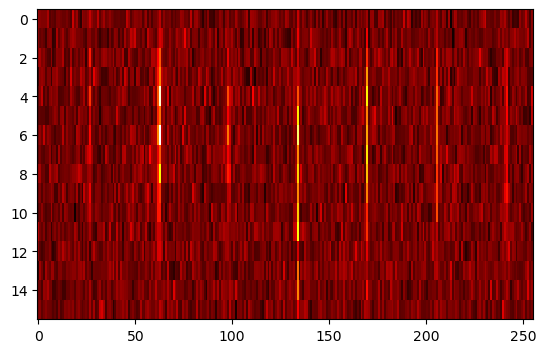

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(SOI[:, 0,:], cmap='hot', interpolation='nearest', aspect=10)

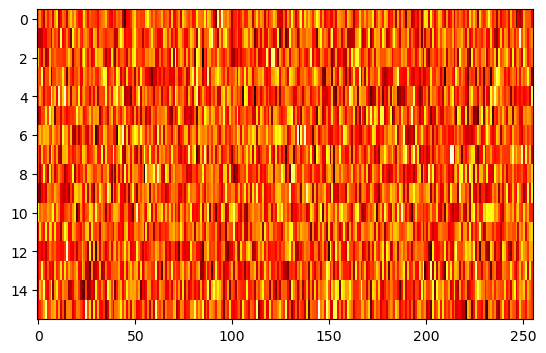

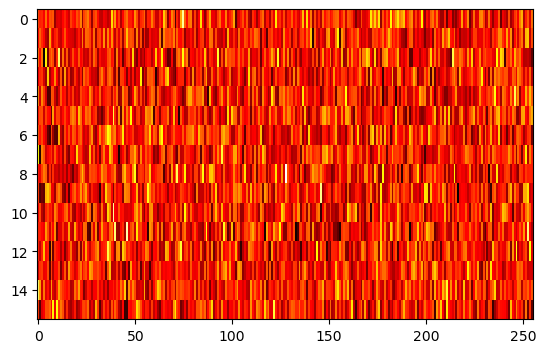

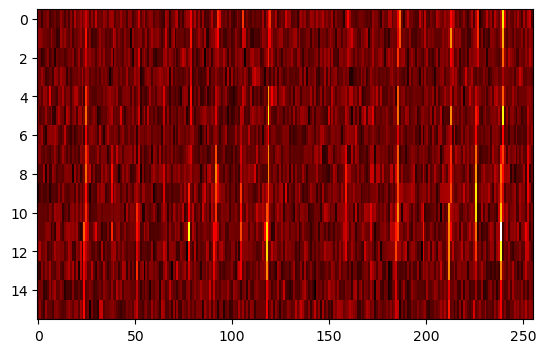

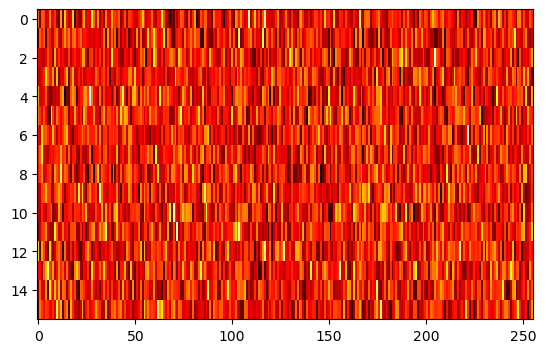

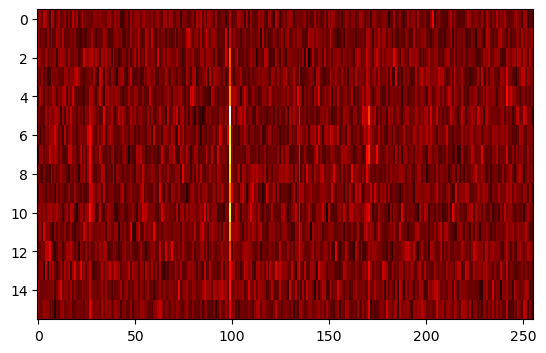

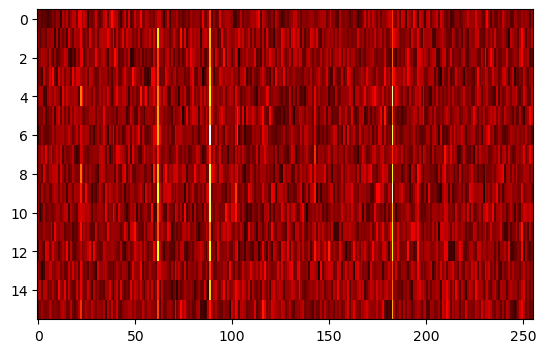

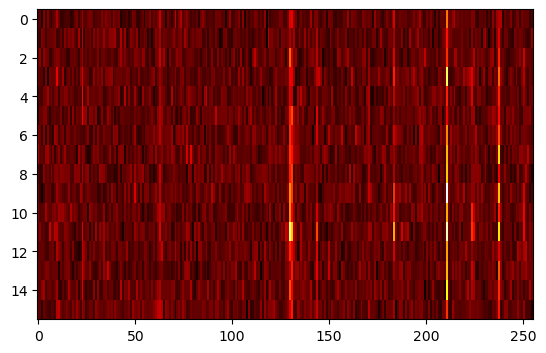

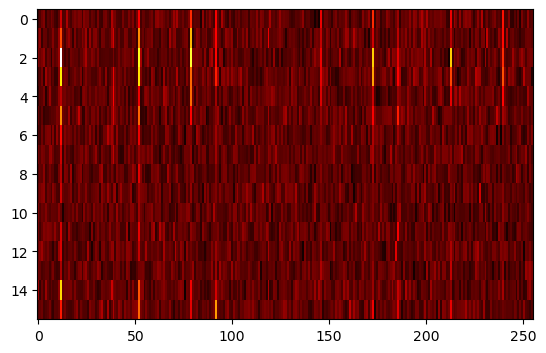

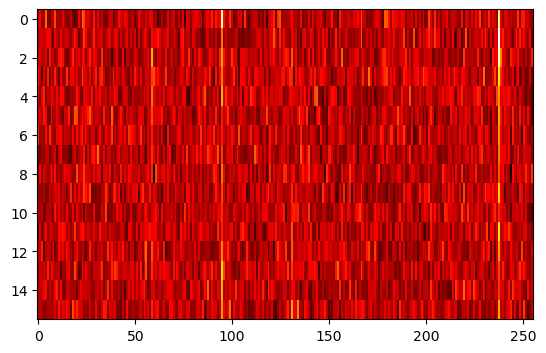

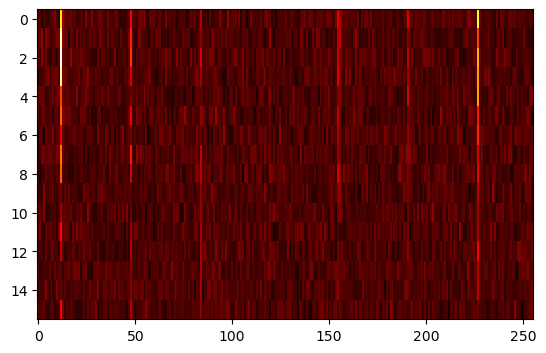

In [18]:
for i in range(10):
    plt.figure()
    plt.imshow(new_total_data[best_index[i],:, :], cmap='hot', interpolation='nearest', aspect=10)